Notebook created: 2018-05-21 04:52:54  
Generated from: _build_py/py/mccall_model.rst  

In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import quantecon as qe
from quantecon.distributions import BetaBinomial

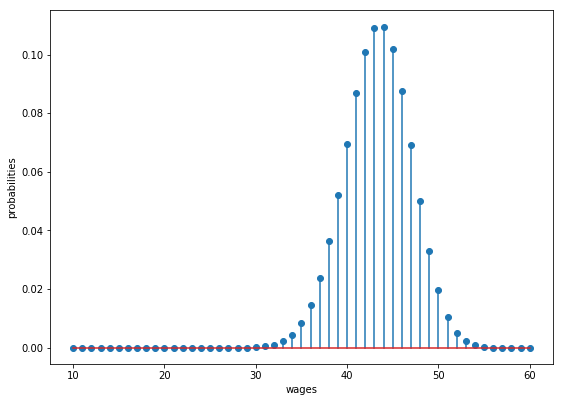

In [2]:
n, a, b = 50, 200, 100
# n, a, b = 500, 200, 100
w_min, w_max = 10, 60
w_vals = np.linspace(w_min, w_max, n+1)
dist = BetaBinomial(n, a, b)
p_vals = dist.pdf()

fig, ax = plt.subplots(figsize=(9, 6.5))
ax.stem(w_vals, p_vals, label='$p_i$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

In [3]:
np.sum(p_vals)

1.0000000000002227

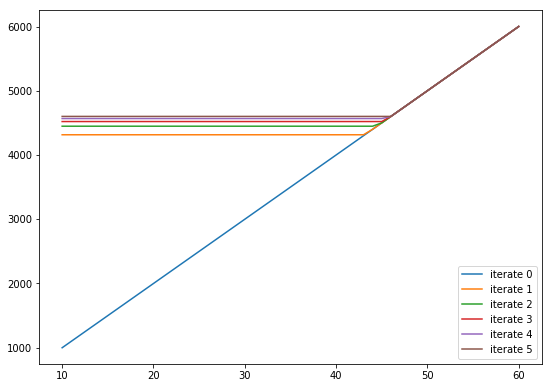

In [4]:
def plot_value_function_seq(ax,
                            c=25,
                            β=0.99,
                            w_vals=w_vals,
                            p_vals=p_vals,
                            num_plots=6):

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(w_vals, v, label=f"iterate {i}")
        # Update guess
        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * p_vals)
            v_next[j] = max(stop_val, cont_val)
        v[:] = v_next

    ax.legend(loc='lower right')


fig, ax = plt.subplots(figsize=(9, 6.5))
plot_value_function_seq(ax)
plt.show()

In [5]:
def compute_reservation_wage(c=25,
                             β=0.99,
                             w_vals=w_vals,
                             p_vals=p_vals,
                             max_iter=500,
                             tol=1e-6):

    # == First compute the value function == #

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * p_vals)
            v_next[j] = max(stop_val, cont_val)

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * p_vals))



In [6]:
%%timeit
compute_reservation_wage()

68.4 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
@jit(nopython=True)
def compute_reservation_wage(c=25,
                             β=0.99,
                             w_vals=w_vals,
                             p_vals=p_vals,
                             max_iter=500,
                             tol=1e-6):

    # == First compute the value function == #

    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * p_vals)
            v_next[j] = max(stop_val, cont_val)

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * p_vals))

In [8]:
%%timeit
compute_reservation_wage()

2.95 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
compute_reservation_wage()

47.316499710024964

In [10]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        R[i, j] = compute_reservation_wage(c=c, β=β)

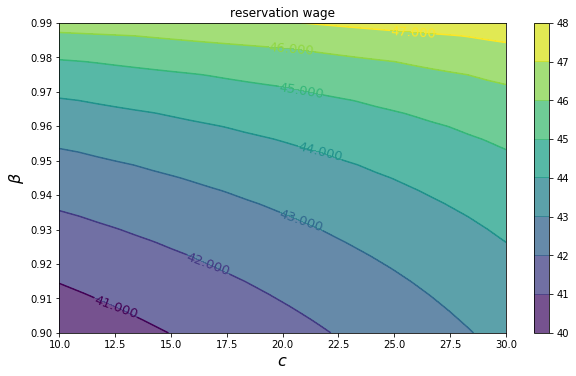

In [11]:
fig, ax = plt.subplots(figsize=(10, 5.7))

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

In [12]:
@jit(nopython=True)
def compute_reservation_wage_two(c=25,
                                 β=0.99,
                                 w_vals=w_vals,
                                 p_vals=p_vals,
                                 max_iter=500,
                                 tol=1e-5):

    # == First compute ψ == #

    ψ = np.sum(w_vals * p_vals) / (1 - β)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        s = np.maximum(w_vals / (1 - β), ψ)
        ψ_next = c + β * np.sum(s * p_vals)

        error = np.abs(ψ_next - ψ)
        i += 1

        ψ = ψ_next

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * ψ)

In [13]:
np.maximum([1,2,3], 2)

array([2, 2, 3])

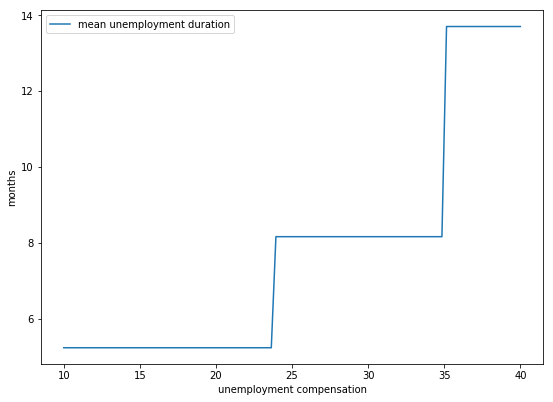

Wall time: 4.21 s


In [14]:
%%time
cdf = np.cumsum(p_vals)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_vals[qe.random.draw(cdf)]
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=10000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

c_vals = np.linspace(10, 40, 100)
stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    w_bar = compute_reservation_wage_two(c=c)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots(figsize=(9, 6.5))

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

`n=500` up at the top (to make `w_vals` finer) and `num_reps=10000` makes for a smooth enough picture that runs in 22 seconds on my machine.